# ML model in pytorch:

## Setting up:
### Additional installations

In [ ]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip install -U -q PyDrive
! pip uninstall shapely
! pip install shapely --no-binary shapely
! pip install sewar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 58.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.4 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp39-cp39-linux_x86_64.whl size=11113647 sha256=b46c6e273544872cf3f93659ff451574d37299ddd6766994182a5844fc3bf293
  Stored in directory: /root/.cache/pip/wheels/74/b9/f5/2c94acd7cd21480e6cf63169144d7aac3e8d9cf638225ed578
Successfully built cartopy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━

### Imports:

In [ ]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos, sin, pi
import random as rn
from google.colab import auth
from google.colab import files

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split

# import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up CUDA:

In [ ]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    print(f"ID of current CUDA device:{torch.cuda.current_device()}")

    print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device:0
Name of current CUDA device:Tesla T4


### Constants:

In [ ]:
# Constants:
DOWNLOAD_FROM_GC = False

fileUPRCM = "MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc"
fileTarget = "MAR(ACCESS1-3)_monthly.nc"
fileGCM = "ACCESS1-3-stereographic_monthly_cleaned.nc"

REGION = 'Larsen' # Antarctic Peninsula
SIZE_INPUT_DOMAIN = 32  # size of input to model (GCM) batch x SIZE_INPUT_DOMAIN x SIZE_INPUT_DOMAIN x num_channels

# Training constants:
BATCH_SIZE = 100
SEED = 0


### Helper scripts:

In [ ]:
# Load configuration file:
from dataFunctions import *
from makeInputs import *

# Unet scripts:
from RCM_Emulator_UNet import *
from training import *
from prediction import *
from metrics import *
from reproducibility import *

# Import custom scripts
#sys.path.append('../')
#from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:
(Not used)

In [ ]:
"""
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt"""

"\nauth.authenticate_user()\n# Give our project ID\nproject_id = 'ee-iceshelf-gee4geo'\n!gcloud config set project {project_id}\n# Download the file from a given Google Cloud Storage bucket.\n!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt\n# Print the result to make sure the transfer worked.\n!cat /tmp/gsutil_download.txt"

### Set up Google Drive:
Mount google drive to access the files

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Googledrive = GoogleDrive(gauth)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/My\ Drive/EPFL/RCM-emulator/saved_models/

MODEL_2022-07-01_Larsen_30_100_Attention_NRMSE.pth
MODEL_2022-07-01_Larsen_40_100_Attention_NRMSE.pth
MODEL_2022-07-14_Larsen_50_100_Baseline_NRMSE.pth
MODEL_2023-04-27_Larsen_29_100_Attention_NRMSE.pth
MODEL_2023-04-27_Larsen_31_100_Attention_NRMSE.pth


## Load data:

### (Input 1) Upscaled regional climate model: UPRCM 
Upscaled MAR(ACCESS-1.3), for perfect model framework

In [ ]:
# If files ar on google cloud
if DOWNLOAD_FROM_GC:
    print("Downloading from google cloud:")
    downloadFileFromGC(pathGC, "", fileUPRCM)
    UPRCM = xr.open_dataset(fileUPRCM)
    os.remove(fileUPRCM)
else:
    # If they're on google drive
    print("Downloading from google drive:")
    idUPRCM = "1ab88hzzd5D9RIDsI6LdGAKO6DFo_R3L2"
    downloaded = Googledrive.CreateFile({"id": idUPRCM})
    downloaded.GetContentFile(fileUPRCM)
    UPRCM = xr.open_dataset(fileUPRCM)
    os.remove(fileUPRCM)
print(UPRCM.dims)
UPRCM["EW"].attrs["long_name"] = "Eastward Near-Surface Wind"
UPRCM

Frozen({'x': 90, 'y': 25, 'time': 1452})


<xarray.Dataset>
Dimensions:      (x: 90, y: 25, time: 1452)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    SF           (time, y, x) float32 ...
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    TTP          (time, y, x) float64 ...
    QQP          (time, y, x) float64 ...
    PR           (time, y, x) float32 ...
    NW           (time, y, x) float64 ...
    EW           (time, y, x) float64 ...
Attributes:
    crs:      3031

Example of the input in South Polar and PlateCarree projections:

/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


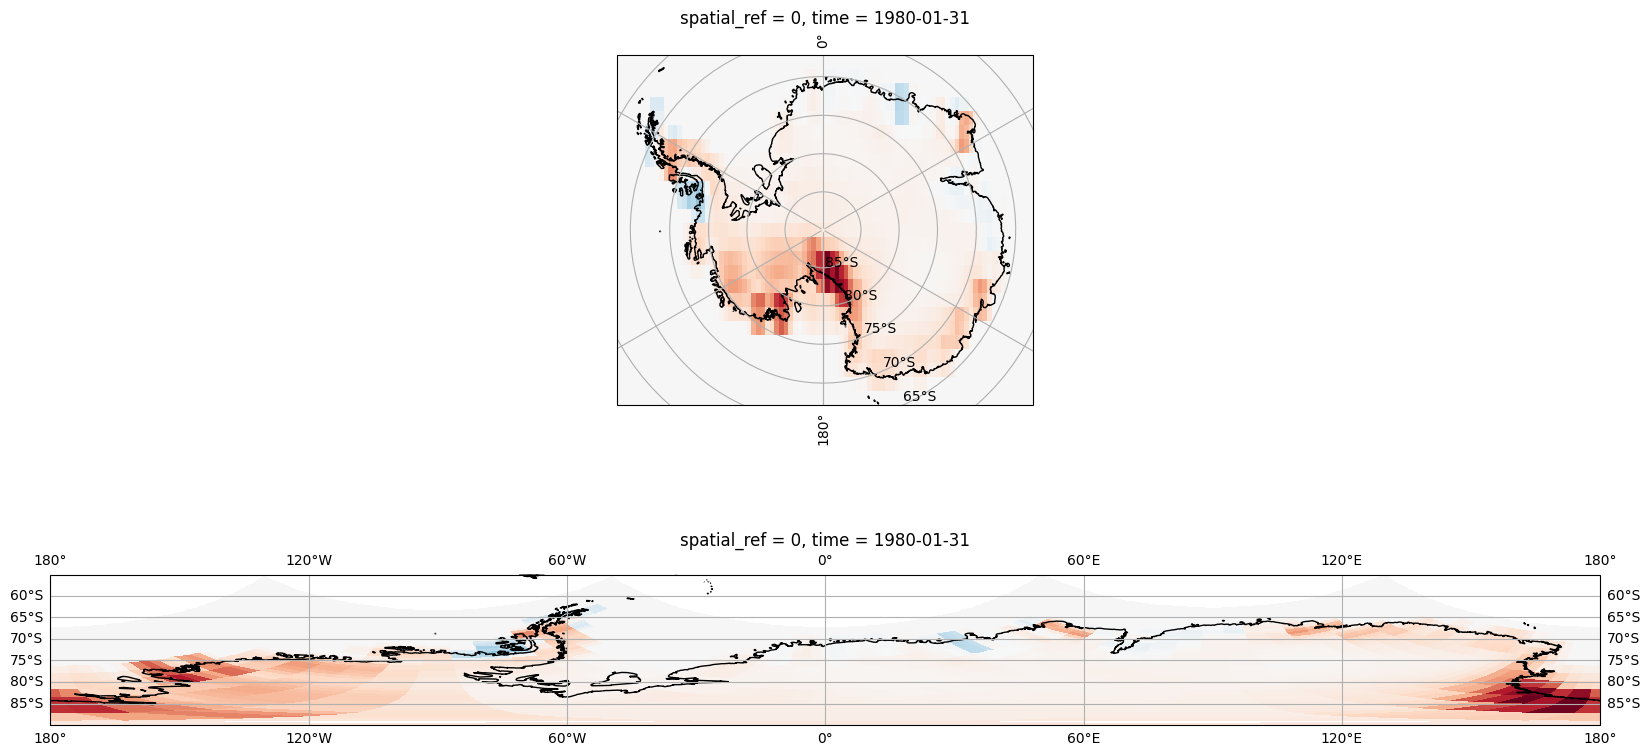

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
UPRCM.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
UPRCM.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

### (Input 2) Global climate model: GCM - ACCESS 1.3
For imperfect model framework 

In [ ]:
%%time
if DOWNLOAD_FROM_GC:
    print("Downloading from google cloud:")
    downloadFileFromGC(pathGC, "", fileGCM)
    UPRCM = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
else:
    print("Downloading from google drive:")
    idGCM = "1Rq4tIPxNTPtTonaMe1gi6PxHmLwgy8D-"
    downloaded = Googledrive.CreateFile({"id": idGCM})
    downloaded.GetContentFile(fileGCM)
    GCM = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
# Rename variables to give same names as in UPRCM/RCM
GCM = GCM.rename_vars(
    {
        "ps": "SP",
        "uas": "EW",
        "vas": "NW",
        "pr": "PR",
        "tas": "TT",
        "rsds": "SWD",
        "rlds": "LWD",
        "huss": "QQP",
        "hurs": "RH",
    }
)
GCM

CPU times: user 1.84 s, sys: 334 ms, total: 2.18 s
Wall time: 11.3 s


<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Data variables:
    QQP          (time, y, x) float32 ...
    RH           (time, y, x) float32 ...
    PR           (time, y, x) float64 ...
    TT           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    NW           (time, y, x) float32 ...
    EW           (time, y, x) float32 ...
Attributes: (12/29)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1.3
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    title:                  ACCESS1-3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0
    crs:                    3031

### (Target) Regional climate model: MAR(ACCESS-1.3)

In [ ]:
%%time
if DOWNLOAD_FROM_GC:
    print("Downloading from google cloud:")
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    print("Downloading from google drive:")
    idTarget = "1r8mVOIo6GDTe6fHb9EZikZMdwPHurHSe"
    downloaded = Googledrive.CreateFile({"id": idTarget})
    downloaded.GetContentFile(fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
# Cut a small part of on the right that is not too important
print("Initial target dimensions:", target_dataset.dims)
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000
target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("Target dimensions after cutting x:", target_dataset.dims)
target_dataset

Initial target dimensions: Frozen({'time': 1452, 'x': 176, 'y': 148})
Target dimensions after cutting x: Frozen({'time': 1452, 'y': 148, 'x': 160})
CPU times: user 1.81 s, sys: 659 ms, total: 2.47 s
Wall time: 8.65 s


<xarray.Dataset>
Dimensions:      (time: 1452, y: 148, x: 160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.8e+06 -2.765e+06 ... 2.73e+06 2.765e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Data variables:
    SMB          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

### Explore variables:

#### GCM over Antarctic Peninsula:

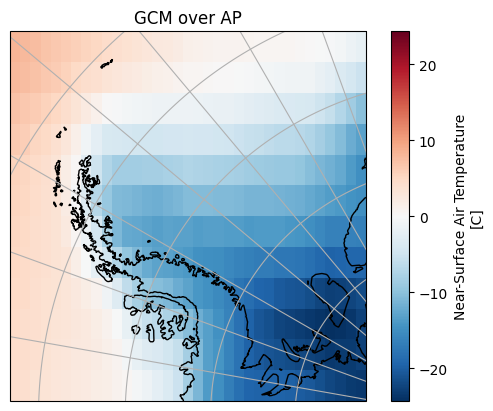

In [ ]:
# Look at GCM resolution of Antarcitc Peninsula
ds = createLowerInput(GCM, region="Larsen", Nx=35, Ny=25, print_=False)
ds = ds.where(ds.y > 0, drop=True)
ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ds.TT.isel(time=1).plot(x="x", ax=ax, transform=ccrs.SouthPolarStereo())
ax.coastlines("10m", color="black")
ax.set_title('GCM over AP')
ax.gridlines()

#### UPRCM vs GCM:

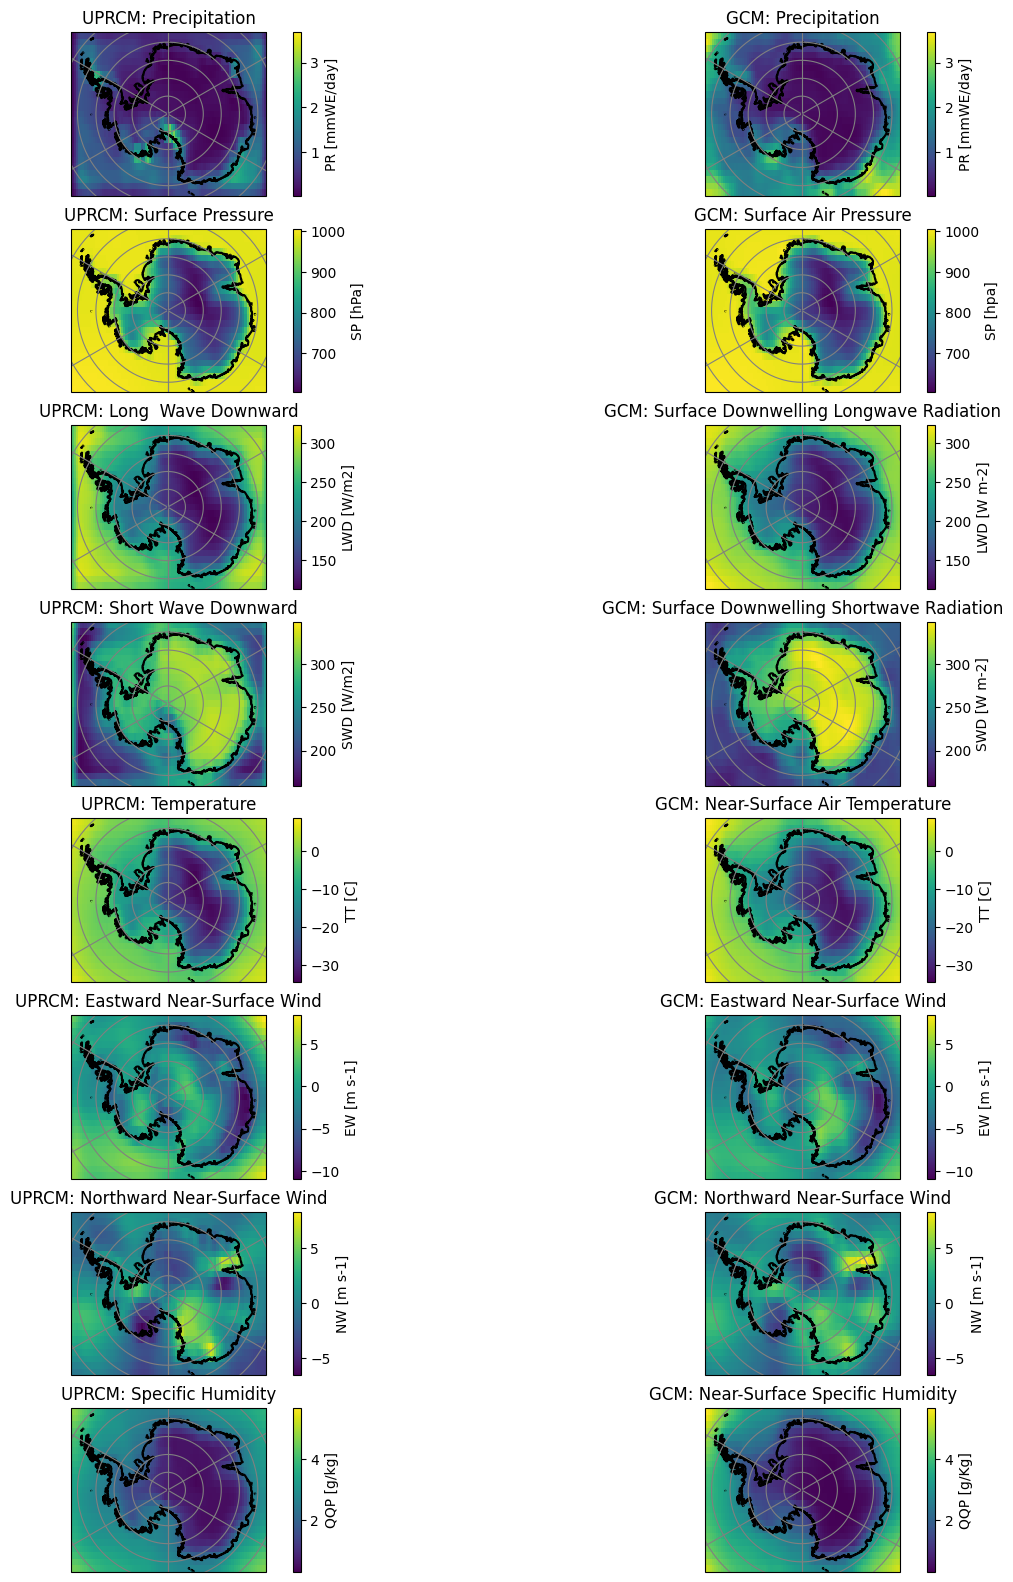

In [ ]:
vars = ["PR", "SP", "LWD", "SWD", "TT", "EW", "NW", "QQP"]
plotAllVar2Xr(UPRCM.drop(["SMB"]), GCM, m=8, n=2, vars_=vars)

## Create input and target for U-Net:

As input features, the RCM-emulator receives a two-dimensional array $X$ and a one-dimensional array $Z$. $X$ is an array that contains images of normalized monthly means ($\tilde{V}_{t,x} \in \mathbb{R}^{D}$) of eight different climate variables $x \in C_1$ at near surface level over domain $D$ and $T$ months. For each climate variable $x$ and month $t$, each image $V_{t,x}$ is normalized according to its own spatial mean and standard deviation before providing them as inputs to the RCM-emulator

**Z**: $Z$ is a one-dimensional temporal encoding of the eight climate variables and includes the time series of spatial means $\bar{V}_{t,x}$ and standard deviations $\sigma(V_{t,x})$ for each $x\in C_1$ and $t\in T$
- Daily spatial means and standard deviations time series for each $X_{i,j,m}$ (because normalising 2D variables removes temporal information)
- Cosinus, sinus vector to encode information about day of year

**X**: Overall, the input feature $X$ contains $T*C_1$ normalised images of dimension $D$ --> SHAPE `[nbmonths, x, y, nb_vars]`. For PyTorch, need to put it into `[nbmonths, nb_vars, x, y]`

### Inputs:
Global-scale (coarse) variables at GCM resolution.

In [ ]:
# variables in UPRCM
all_vars_RCM = sorted(list(UPRCM.data_vars))
print("All variables in (UP)RCM:", all_vars_RCM)

# variables we want to train on:
vars = ["PR", "SP", "LWD", "SWD", "TT", "UUP", "VVP", "QQP"]
print("Variables we want to train on:", vars)
# difference between both
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

print("Variables to drop from (UP)RCM:", Diff(all_vars_RCM, vars))

All variables in (UP)RCM: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'RF', 'SF', 'SMB', 'SP', 'SWD', 'TT', 'TTP']
Variables we want to train on: ['PR', 'SP', 'LWD', 'SWD', 'TT', 'UUP', 'VVP', 'QQP']
Variables to drop from (UP)RCM: ['NW', 'SMB', 'SF', 'RF', 'TTP', 'EW', 'UUP', 'VVP']


#### UPRCM:
(Perfect model framework) 

In [ ]:
# UPRCM input:
i1D_uprcm, i2D_uprcm, i1D_ns_uprcm, i2D_ns_uprcm, VAR_LIST = make_inputs(
    UPRCM=UPRCM,
    GCM=None,
    size_input_domain=SIZE_INPUT_DOMAIN,
    Region=REGION,
    dropvarGCM=None,
    dropvarRCM=["RF", "SF", "TTP"],
)
REGIONS = [REGION]

# Full input to model:
full_input_uprcm = [
    np.concatenate([i2D_uprcm], axis=0),
    np.concatenate([i1D_uprcm], axis=0),
]
# Non standardised version for plots:
full_input_ns_uprcm = [
    np.concatenate([i2D_ns_uprcm], axis=0),
    np.concatenate([i1D_ns_uprcm], axis=0),
]

#### GCM:
(Imperfect model framework) 

In [ ]:
# GCM input
i1D_GCM, i2D_GCM, i1D_ns_GCM, i2D_ns_GCM, VAR_LIST = make_inputs(
    UPRCM=UPRCM,
    GCM=GCM,
    size_input_domain=SIZE_INPUT_DOMAIN,
    Region=REGION,
    dropvarGCM=None,
    dropvarRCM=["RF", "SF", "TTP"],
)
full_input_GCM = [np.concatenate([i2D_GCM], axis=0), np.concatenate([i1D_GCM], axis=0)]

# Non standardised version for plots:
full_input_ns_GCM = [
    np.concatenate([i2D_ns_GCM], axis=0),
    np.concatenate([i1D_ns_GCM], axis=0),
]

### Target:

Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)
Input 2D: (1452, 32, 32, 8)
Input 1D: (1452, 1, 1, 18)


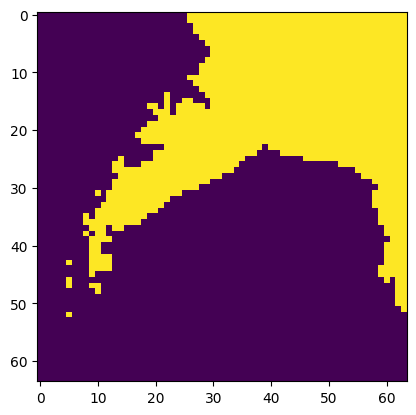

In [ ]:
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input_GCM[0].shape)
print("Input 1D:", full_input_GCM[1].shape)

mask = createMask(full_target[0,:,:], onechannel = True)
plt.imshow(mask)

### Examples of input vs target of model:
(UPRCM vs Target)

2D Feature batch shape: torch.Size([100, 8, 32, 32])
1D Feature batch shape: torch.Size([100, 18, 1, 1])
Labels batch shape: torch.Size([100, 1, 64, 64])


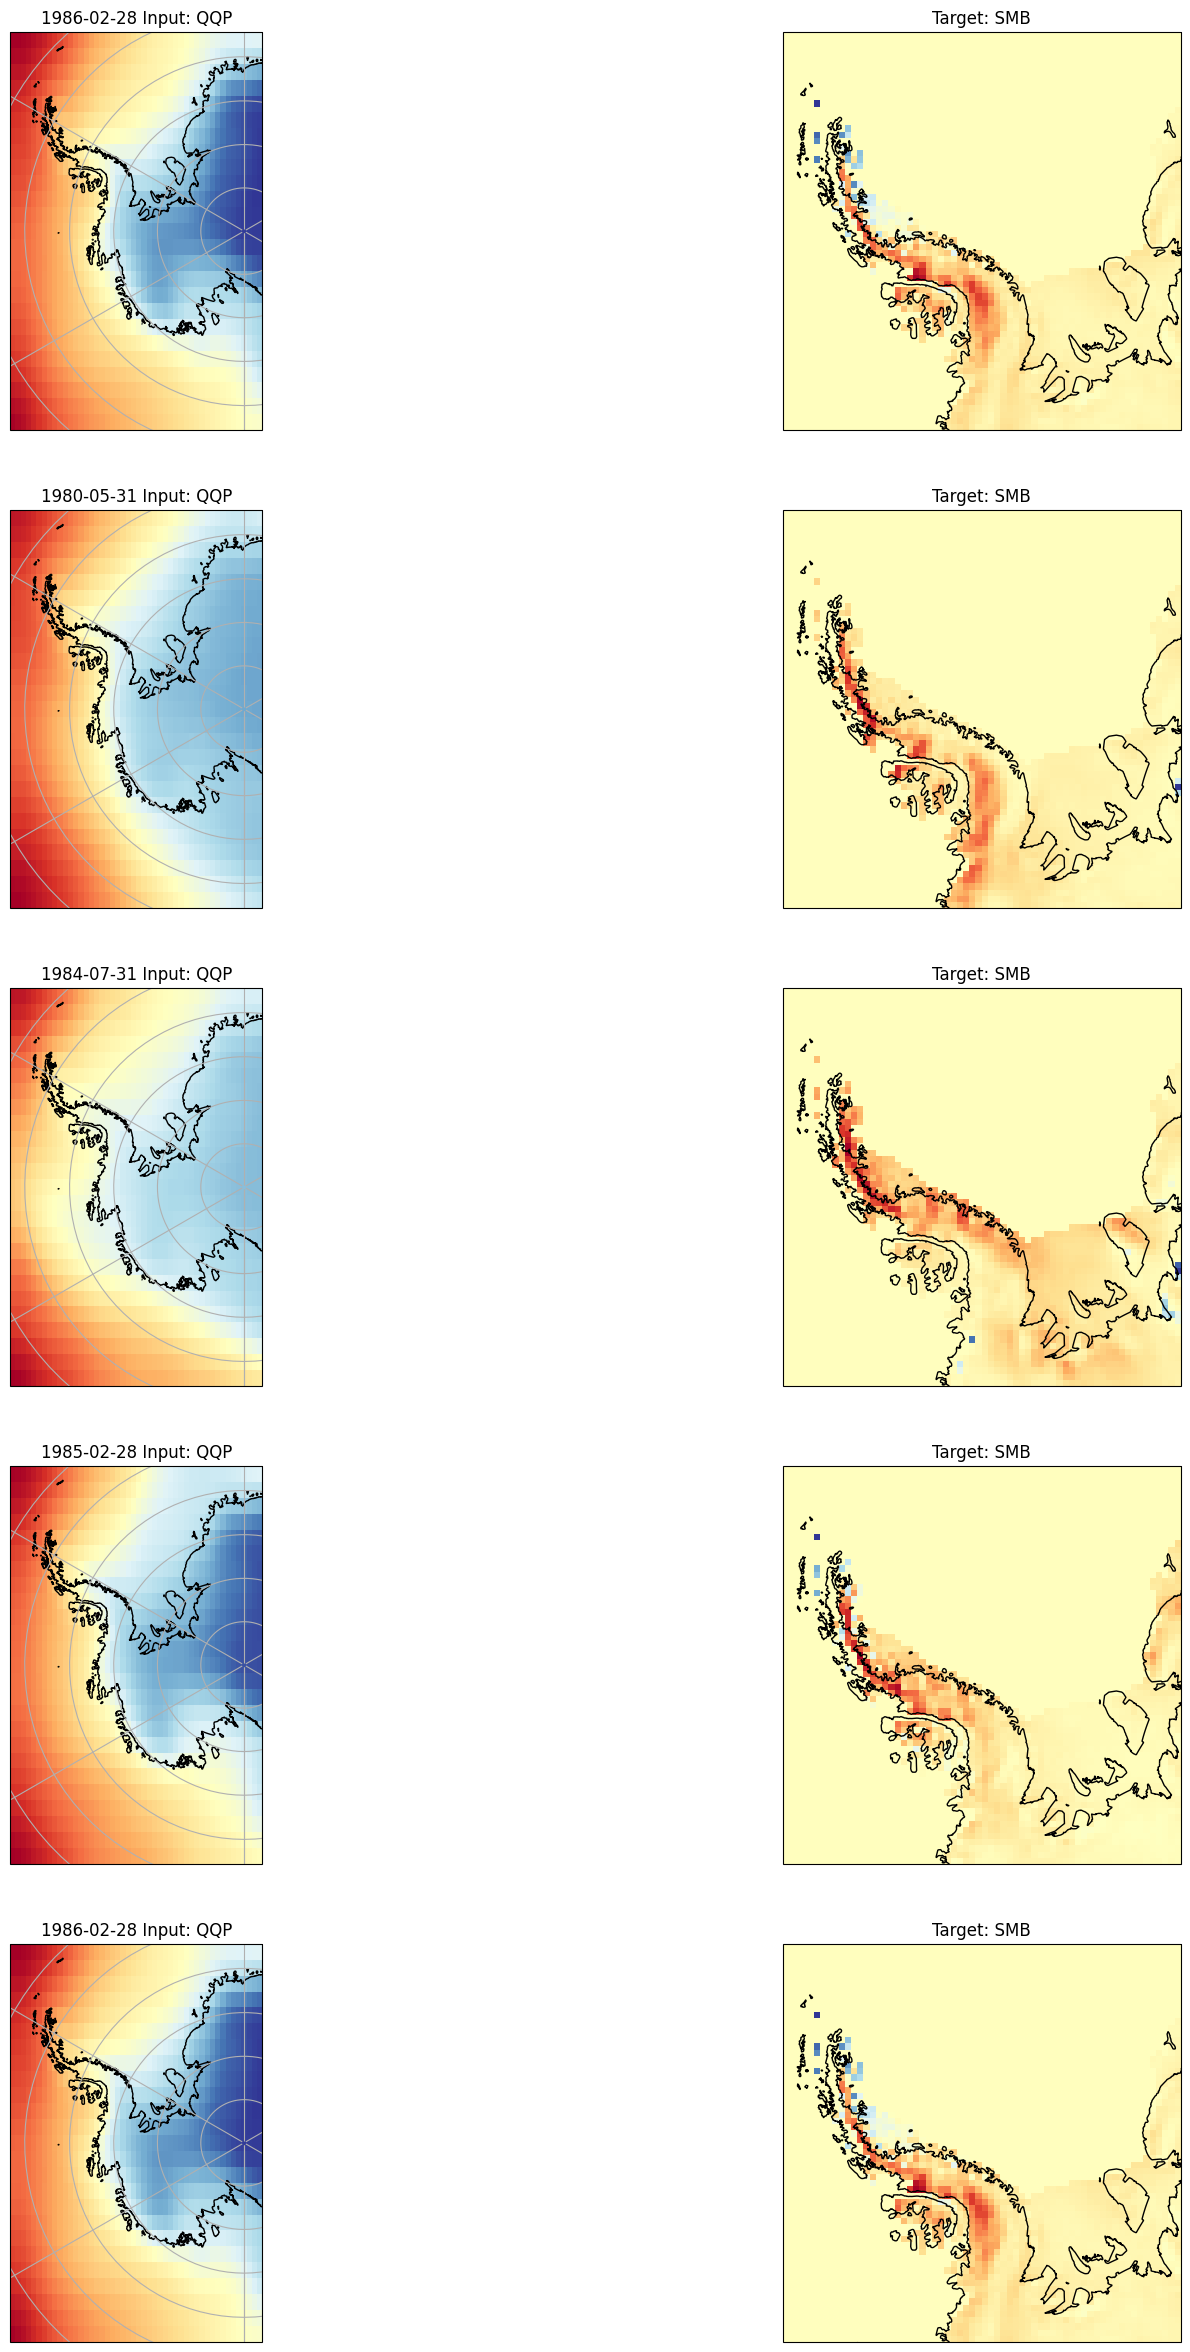

In [ ]:
#  Create PyTroch tensors:
X = torch.tensor(full_input_uprcm[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input_uprcm[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))
R = regionEncoder(X, REGION, REGIONS)  # region encoder

# 1. Create dataset
dataset = TensorDataset(X, Z, Y, R)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Example:
(x, z, y, r) = next(iter(loader))
print(f"2D Feature batch shape: {x.size()}")
print(f"1D Feature batch shape: {z.size()}")
print(f"Labels batch shape: {y.size()}")

# Display input and targets.
N = 5
f = plt.figure(figsize=(20, 30))

for i in range(N):
    train_X, train_Z, train_Y, train_R = next(iter(loader))
    randTime = rn.randint(0, len(train_X) - 1)
    sample2dtrain_ = train_X.numpy().transpose(0, 2, 3, 1)[randTime]
    sampletarget_ = train_Y.numpy().transpose(0, 2, 3, 1)[randTime]
    sampleregion = train_R[randTime]
    
    # get time in datetime format:
    time = str(pd.to_datetime([UPRCM.time.isel(time=randTime).values]).date[0])

    sample2dtrain_ = resize(sample2dtrain_, 25, 48, print_=False)

    vmin, vmax = np.min(sampletarget_), np.max(sampletarget_)

    M = 2
    for m in range(M):
        if m == 0:
            ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotTrain(
                UPRCM,
                sample2dtrain_,
                4,
                ax,
                time,
                VAR_LIST,
                region=REGIONS[sampleregion],
            )
        if m == 1:
            ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotTarget(
                target_dataset,
                sampletarget_,
                ax,
                vmin,
                vmax,
                region=REGIONS[sampleregion],
            )

## Train U-Net:

#### Train/Val/Test split:

In [ ]:
"""print('Seed:',SEED)

#  Create pytorch tensors:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))
R = regionEncoder(X, REGION)  # region encoder

# 2. Split into train / validation partitions
n_val = int(len(dataset) * VAL_PERCENT)
n_train = len(dataset) - n_val
train_set, val_set = random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)
)

# 3. Create data loaders
loader_args = dict(batch_size=BATCH_SIZE)
train_loader = DataLoader(train_set, shuffle=False, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE)"""

"print('Seed:',SEED)\n\n#  Create pytorch tensors:\nX = torch.tensor(full_input[0].transpose(0, 3, 1, 2))\nZ = torch.tensor(full_input[1].transpose(0, 3, 1, 2))\nY = torch.tensor(full_target.transpose(0, 3, 1, 2))\nR = regionEncoder(X, REGION)  # region encoder\n\n# 2. Split into train / validation partitions\nn_val = int(len(dataset) * VAL_PERCENT)\nn_train = len(dataset) - n_val\ntrain_set, val_set = random_split(\n    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)\n)\n\n# 3. Create data loaders\nloader_args = dict(batch_size=BATCH_SIZE)\ntrain_loader = DataLoader(train_set, shuffle=False, batch_size=BATCH_SIZE)\nval_loader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE)"

### Imperfect MF - Train on RCM:

In the perfect model framework, the RCM-emulator learns only the downscaling function, similar to classical super-resolution approaches; therefore, it was trained with upscaled RCM features at GCM resolution.

Region: Larsen

Type: Attention 

Loss: NRMSE

In [ ]:
%%time
print('Seed:',SEED)
LOSS_ = 'NRMSE'
TYPENET = 'Attention'

# path to save model to on Google drive
pathGD = "/content/gdrive/My Drive/EPFL/RCM-emulator/saved_models/"

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=False,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss_ = LOSS_, 
    typeNet = TYPENET,
    ignoreSea = False,
    nrmse_maxmin = True, # normalise by (max-min) or by mean of target
    earlystopping = 15,
    path_GD = pathGD
)
print('Training parameters:\n',trainingParam)
# Load datasets and U-Net 
train_loss_e, val_loss_e, train_set, test_set, net, nameModel, num_epoch = trainFlow(
    full_input_uprcm,
    full_target,
    torch.tensor(mask),
    region=REGION,
    regions = REGIONS,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test, 
    **trainingParam
)

Seed: 0
Training parameters:
 {'num_epochs': 50, 'batch_size': 100, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'path_GD': '/content/gdrive/My Drive/EPFL/RCM-emulator/saved_models/'}


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 14/50: 100%|██████████| 1066/1066 [00:13<00:00, 81.56timestep/s, loss (batch)=0.00907]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 22/50: 100%|██████████| 1066/1066 [00:13<00:00, 79.33timestep/s, loss (batch)=0.00752]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/50: 100%|██████████| 1066/1066 [00:13<00:00, 78.89timestep/s, loss (batch)=0.00727]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/50: 100%|██████████| 1066/1066 [00:12<00:00, 82.29timestep/s, loss (batch)=0.00726]


CPU times: user 3min 21s, sys: 1min 40s, total: 5min 2s
Wall time: 7min 4s


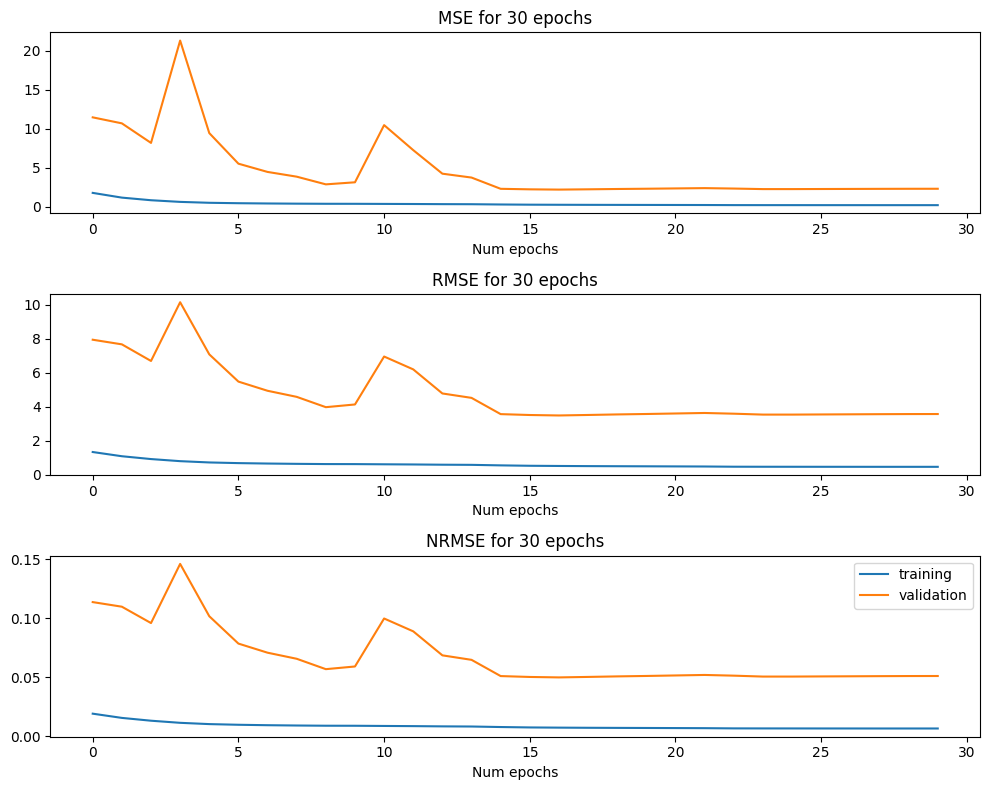

In [ ]:
plotLoss(train_loss_e, val_loss_e, num_epoch+1)

### Imperfect MF - Train on GCM:

In [ ]:
%%time
print('Seed:',SEED)
LOSS_ = 'NRMSE'
TYPENET = 'Attention'

# path to save model to on Google drive
pathGD = "/content/gdrive/My Drive/EPFL/RCM-emulator/saved_models/"

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=False,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss_ = LOSS_, 
    typeNet = TYPENET,
    ignoreSea = False,
    nrmse_maxmin = True, # normalise by (max-min) or by mean of target
    earlystopping = 15,
    path_GD = pathGD
)
print('Training parameters:\n',trainingParam)
# Load datasets and U-Net 
train_loss_e_gcm, val_loss_e_gcm, train_set_gcm, test_set_gcm, net_gcm, nameModel_gcm, num_epoch_gcm = trainFlow(
    full_input_GCM,
    full_target,
    torch.tensor(mask),
    region=REGION,
    regions = REGIONS,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test, 
    **trainingParam
)

Seed: 0
Training parameters:
 {'num_epochs': 50, 'batch_size': 100, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'path_GD': '/content/gdrive/My Drive/EPFL/RCM-emulator/saved_models/'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▆▄▄▄▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂▁▂▁▁▂▂▂
validation mse,▇▆▆▅▅▅█▃▃▂▄▁▃▂█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
learning rate,1e-05
step,330
train loss,0.00726
validation mse,0.00929


Epoch 16/50: 100%|██████████| 1066/1066 [00:13<00:00, 79.59timestep/s, loss (batch)=0.00963]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 22/50: 100%|██████████| 1066/1066 [00:13<00:00, 78.16timestep/s, loss (batch)=0.00781]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/50: 100%|██████████| 1066/1066 [00:13<00:00, 76.53timestep/s, loss (batch)=0.00756]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


Epoch 32/50: 100%|██████████| 1066/1066 [00:13<00:00, 76.97timestep/s, loss (batch)=0.00754]


Epoch 00032: reducing learning rate of group 0 to 5.0000e-07.
CPU times: user 3min 32s, sys: 1min 52s, total: 5min 25s
Wall time: 7min 40s


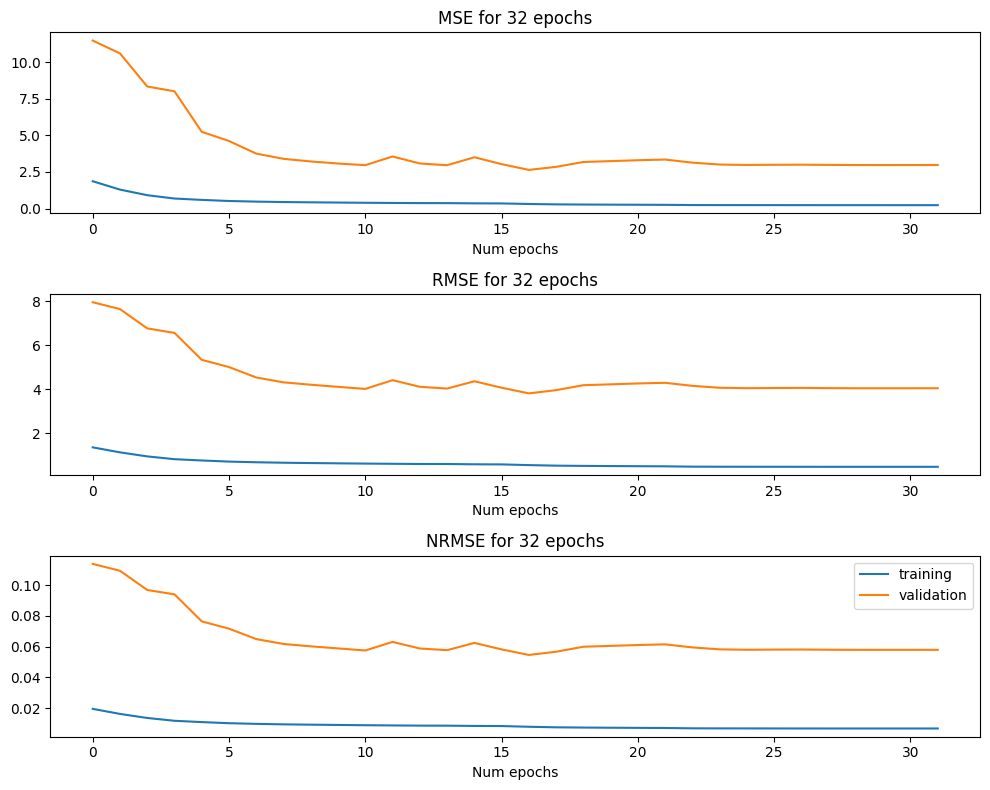

In [ ]:
plotLoss(train_loss_e_gcm, val_loss_e_gcm, num_epoch_gcm+1)

In [ ]:
def plotLoss_imp_perf(train_loss_e, val_loss_e, train_loss_e_gcm, val_loss_e_gcm):
    f = plt.figure(figsize=(10, 4))
    ax = plt.subplot(1, 2, 1)
    ax.plot(train_loss_e["NRMSE"], label="training")
    ax.plot(val_loss_e["NRMSE"], label="validation")
    ax.set_title(f"NRMSE loss for perfect model framework")
    ax.set_xlabel("Num epochs")

    ax = plt.subplot(1, 2, 2)
    ax.plot(train_loss_e_gcm["NRMSE"], label="training")
    ax.plot(val_loss_e_gcm["NRMSE"], label="validation")
    ax.set_title(f"NRMSE loss for imperfect model framework")
    ax.set_xlabel("Num epochs")

    plt.legend()
    plt.savefig('train-loss.pdf')

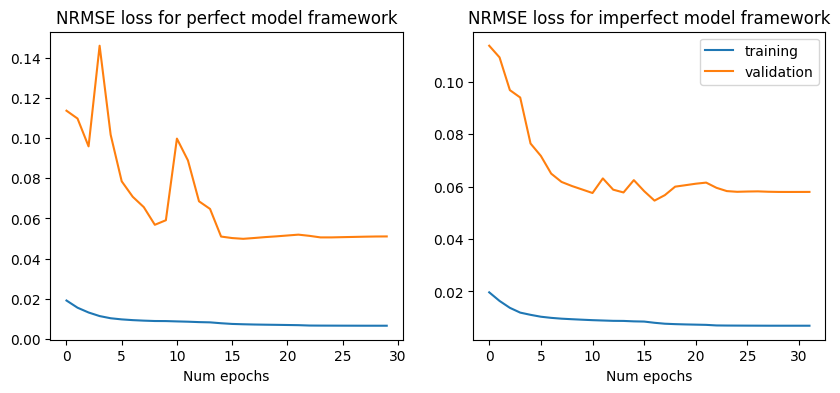

In [ ]:
plotLoss_imp_perf(train_loss_e, val_loss_e, train_loss_e_gcm, val_loss_e_gcm)
